
# Dengue Forecast Experiment v3

เวอร์ชันทดลองนี้เพิ่มขั้นตอน feature selection เพื่อให้โมเดล LightGBM + MLForecast ใช้ฟีเจอร์ที่มีประสิทธิภาพสูงสุด โดยแบ่งข้อมูลตามเวลาเพื่อหลีกเลี่ยง data leakage และสรุปผลบนชุด hold-out เหมือนเดิม.


In [21]:

import warnings
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from mlforecast import MLForecast

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
RNG_SEED = 2025
np.random.seed(RNG_SEED)


In [22]:

DATA = Path('/teamspace/studios/this_studio/data/dengue')
INTERIM = DATA / 'interim'
FEATURES = DATA / 'features'
REPORTS = DATA / 'reports'
MODELS = DATA / 'models'
for folder in [REPORTS, MODELS]:
    folder.mkdir(parents=True, exist_ok=True)

feature_path = FEATURES / 'feature_matrix_weekly.parquet'
coords_path = INTERIM / 'district_coords.csv'
assert feature_path.exists(), f'missing {feature_path}'
assert coords_path.exists(), f'missing {coords_path}'

df = pd.read_parquet(feature_path).copy()
coords = pd.read_csv(coords_path).drop_duplicates('district_id_txt_clean')

print('Weekly feature matrix:', df.shape)
print('Coords table:', coords.shape)
print('Week span:', df['week_start'].min(), '→', df['week_start'].max())
print('Districts:', df['district_id_txt_clean'].nunique())


Weekly feature matrix: (21369, 94)
Coords table: (76, 3)
Week span: 2018-01-08 00:00:00 → 2024-05-27 00:00:00
Districts: 71


In [23]:

# --- Feature engineering (lagged + cluster context) ---

df = df.sort_values(['district_id_txt_clean', 'week_start']).copy()
df['week_start'] = pd.to_datetime(df['week_start'])

extra_lags = [16, 20, 24]
extra_rolls = [6, 10, 16]
diff_windows = [1, 4]


def enhance_group(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values('week_start').copy()
    for lag in extra_lags:
        g[f'cases_lag{lag}'] = g['cases'].shift(lag)
    for window in extra_rolls:
        g[f'cases_roll{window}_mean'] = g['cases'].rolling(window, min_periods=max(1, window // 2)).mean().shift(1)
        g[f'cases_roll{window}_sum'] = g['cases'].rolling(window, min_periods=max(1, window // 2)).sum().shift(1)
    g['cases_ema4'] = g['cases'].ewm(span=4, adjust=False).mean().shift(1)
    g['cases_ema8'] = g['cases'].ewm(span=8, adjust=False).mean().shift(1)
    g['cases_volatility8'] = g['cases'].rolling(8, min_periods=4).std().shift(1)
    for w in diff_windows:
        prev_cases = g['cases'].shift(1)
        baseline = g['cases'].shift(w + 1)
        g[f'cases_diff{w}'] = prev_cases - baseline
        g[f'cases_pct_change{w}'] = (prev_cases - baseline) / (baseline + 1e-3)
    prev_cases = g['cases'].shift(1)
    prev_prev_cases = g['cases'].shift(2)
    g['cases_ratio1'] = prev_cases / (prev_prev_cases + 1e-3)
    return g


df = df.groupby('district_id_txt_clean', group_keys=False).apply(enhance_group)

df = df.merge(coords[['district_id_txt_clean', 'lat', 'lon']], on='district_id_txt_clean', how='left')
df['lat'] = df['lat'].fillna(df['lat'].mean())
df['lon'] = df['lon'].fillna(df['lon'].mean())

scaler = StandardScaler()
coord_scaled = scaler.fit_transform(df.drop_duplicates('district_id_txt_clean')[['lat', 'lon']])
n_clusters = min(6, df['district_id_txt_clean'].nunique())
kmeans = KMeans(n_clusters=n_clusters, random_state=RNG_SEED, n_init=20)
cluster_labels = kmeans.fit_predict(coord_scaled)
cluster_map = dict(zip(df.drop_duplicates('district_id_txt_clean')['district_id_txt_clean'], cluster_labels))
df['cluster_id'] = df['district_id_txt_clean'].map(cluster_map).astype(int)

cluster_stats = (
    df.groupby(['cluster_id', 'week_start'], as_index=False)['cases']
    .mean()
    .rename(columns={'cases': 'cluster_cases_mean_raw'})
)
df = df.merge(cluster_stats, on=['cluster_id', 'week_start'], how='left')
df['cluster_cases_mean'] = df.groupby('cluster_id')['cluster_cases_mean_raw'].shift(1)
df['cluster_cases_lag1'] = df.groupby('cluster_id')['cluster_cases_mean'].shift(1)
df['cluster_cases_lag4'] = df.groupby('cluster_id')['cluster_cases_mean'].shift(4)
cluster_std = df.groupby('cluster_id')['cases'].transform(lambda x: x.std(ddof=0) + 1e-3)
prev_cases = df.groupby('cluster_id')['cases'].shift(1)
df['cases_zscore_cluster'] = (prev_cases - df['cluster_cases_mean']) / cluster_std
df = df.drop(columns=['cluster_cases_mean_raw'])
df['cases_zscore_cluster'] = df['cases_zscore_cluster'].replace([np.inf, -np.inf], np.nan)

req_cols = ['cases_lag1', 'cases_lag2', 'cases_lag3'] + [f'cases_lag{lag}' for lag in extra_lags]
cluster_cols = ['cluster_cases_mean', 'cluster_cases_lag1', 'cluster_cases_lag4', 'cases_zscore_cluster']
req_cols = [c for c in req_cols if c in df.columns] + [c for c in cluster_cols if c in df.columns]
df = df.dropna(subset=req_cols).reset_index(drop=True)

print('Enhanced feature set shape:', df.shape)


Enhanced feature set shape: (19665, 118)


In [24]:

df_ml = df.rename(columns={
    'district_id_txt_clean': 'unique_id',
    'week_start': 'ds',
    'cases': 'y'
}).copy()

df_ml['ds'] = pd.to_datetime(df_ml['ds'])
df_ml['y'] = pd.to_numeric(df_ml['y'], errors='coerce').clip(lower=0)

df_ml['year'] = df_ml['ds'].dt.year.astype(int)
df_ml['month'] = df_ml['ds'].dt.month.astype(int)
df_ml['weekofyear'] = df_ml['ds'].dt.isocalendar().week.astype(int)
df_ml['sin_woy'] = np.sin(2 * np.pi * df_ml['weekofyear'] / 52.0)
df_ml['cos_woy'] = np.cos(2 * np.pi * df_ml['weekofyear'] / 52.0)

static_candidates = ['province_code', 'district_num', 'cluster_id']
STATIC_FEATS = []
EXCLUDED_STATIC = []
for col in static_candidates:
    if col in df_ml.columns:
        nunique_per_id = df_ml.groupby('unique_id')[col].nunique(dropna=False).max()
        if nunique_per_id == 1:
            STATIC_FEATS.append(col)
        else:
            EXCLUDED_STATIC.append(col)

DATE_FEATS = ['year', 'month', 'weekofyear', 'sin_woy', 'cos_woy']
EXOG_FEATS = [c for c in [
    'temperature_2m_mean', 'temperature_2m_min', 'temperature_2m_max',
    'relative_humidity_2m_mean', 'dewpoint_2m_mean', 'vpd_kpa',
    'precipitation_sum', 'rain_sum', 'shortwave_radiation_sum', 'windspeed_10m_max',
    'ipd_rate', 'fatal_rate', 'age_mean'
] if c in df_ml.columns]

base_feature_cols = {'unique_id', 'ds', 'y'}
extra_feature_cols = sorted(
    c for c in df_ml.columns
    if c not in base_feature_cols
    and c not in STATIC_FEATS
    and c not in DATE_FEATS
    and c not in EXOG_FEATS
)
XCOLS = list(dict.fromkeys(STATIC_FEATS + DATE_FEATS + EXOG_FEATS + extra_feature_cols))

print('Static features:', STATIC_FEATS)
print('Excluded static (vary over time):', EXCLUDED_STATIC)
print('Date features:', DATE_FEATS)
print('Exogenous features:', len(EXOG_FEATS))
print('Extra engineered features:', len(extra_feature_cols))
print('Total predictors:', len(XCOLS))


Static features: ['province_code', 'cluster_id']
Excluded static (vary over time): ['district_num']
Date features: ['year', 'month', 'weekofyear', 'sin_woy', 'cos_woy']
Exogenous features: 13
Extra engineered features: 96
Total predictors: 116


In [25]:

df_ml = df_ml.sort_values(['ds', 'unique_id']).reset_index(drop=True)
last_weeks = 26
unique_ds = df_ml['ds'].drop_duplicates().sort_values()
cut_date = unique_ds.iloc[-last_weeks]
print('Validation start date:', cut_date.date())

df_train = df_ml[df_ml['ds'] < cut_date].copy()
df_valid = df_ml[df_ml['ds'] >= cut_date].copy()

print('Train rows:', len(df_train), '| Valid rows:', len(df_valid))
print('Train weeks:', df_train['ds'].nunique(), '| Valid weeks:', df_valid['ds'].nunique())
print('Validation districts:', df_valid['unique_id'].nunique())


Validation start date: 2023-12-04
Train rows: 19456 | Valid rows: 209
Train weeks: 284 | Valid weeks: 26
Validation districts: 59


In [26]:

MANDATORY_FEATS = list(dict.fromkeys(STATIC_FEATS + DATE_FEATS))
candidate_feats = [feat for feat in XCOLS if feat not in MANDATORY_FEATS]

X_train_full = df_train[XCOLS].copy()
y_train_full = df_train['y'].astype(float).copy()

selector_params = dict(
    objective='poisson',
    metric='rmse',
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=128,
    min_child_samples=60,
    subsample=0.9,
    subsample_freq=1,
    colsample_bytree=0.9,
    reg_alpha=0.2,
    reg_lambda=0.8,
    random_state=RNG_SEED,
    n_jobs=-1
)
base_selector = lgb.LGBMRegressor(**selector_params)
base_selector.fit(X_train_full, y_train_full)

gain_series = pd.Series(base_selector.booster_.feature_importance(importance_type='gain'), index=XCOLS)

tscv = TimeSeriesSplit(n_splits=4)
perm_rows = []
for fold_id, (train_idx, valid_idx) in enumerate(tscv.split(X_train_full), start=1):
    fold_model = lgb.LGBMRegressor(**selector_params)
    fold_model.fit(X_train_full.iloc[train_idx], y_train_full.iloc[train_idx])
    perm = permutation_importance(
        fold_model,
        X_train_full.iloc[valid_idx],
        y_train_full.iloc[valid_idx],
        n_repeats=4,
        random_state=RNG_SEED + fold_id,
        n_jobs=-1
)
    perm_rows.append(pd.Series(perm.importances_mean, index=XCOLS))
perm_series = pd.concat(perm_rows, axis=1).mean(axis=1)


def _normalize(series: pd.Series) -> pd.Series:
    series = series.clip(lower=0)
    denom = series.sum()
    if denom <= 0:
        return pd.Series(0.0, index=series.index)
    return series / denom

combined_score = 0.6 * _normalize(gain_series) + 0.4 * _normalize(perm_series)
if candidate_feats:
    candidate_scores = combined_score.loc[candidate_feats].sort_values(ascending=False)
    coverage = candidate_scores.cumsum()
    selected_mask = coverage <= 0.9
    selected_candidates = candidate_scores.index[selected_mask].tolist()
    if not selected_candidates:
        selected_candidates = candidate_scores.index[:1].tolist()
    if len(selected_candidates) < 30:
        # add highest-scoring leftovers until we reach 30 unique features
        leftovers = [feat for feat in candidate_scores.index if feat not in selected_candidates]
        take = min(30 - len(selected_candidates), len(leftovers))
        selected_candidates.extend(leftovers[:take])
else:
    selected_candidates = []

SELECTED_FEATURES = list(dict.fromkeys(MANDATORY_FEATS + selected_candidates))
print(f'Selected {len(SELECTED_FEATURES)} features (mandatory + top candidates).')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22281


[LightGBM] [Info] Number of data points in the train set: 19456, number of used features: 115
[LightGBM] [Info] Start training from score -0.314702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [27]:

selected_df = pd.DataFrame({
    'feature': SELECTED_FEATURES,
    'mandatory': [feat in MANDATORY_FEATS for feat in SELECTED_FEATURES],
    'score': [float(combined_score.get(feat, 0.0)) for feat in SELECTED_FEATURES]
})
selected_df = selected_df.sort_values('score', ascending=False)
print(selected_df.head(20))


                      feature  mandatory     score
7                    age_mean      False  0.690698
8                    ipd_rate      False  0.095868
9                  cases_ema4      False  0.064249
10                 cases_ema8      False  0.026096
11           cases_roll4_mean      False  0.021586
12           cases_roll6_mean      False  0.016831
13          cases_volatility8      False  0.011771
14       cases_zscore_cluster      False  0.008132
15                 cases_lag2      False  0.004894
16                 cases_lag1      False  0.004303
17     precipitation_sum_lag4      False  0.002236
18   temperature_2m_mean_lag8      False  0.001825
19                        lon      False  0.001515
20               district_num      False  0.001474
21         cluster_cases_lag4      False  0.001452
22          cases_roll16_mean      False  0.001358
23  temperature_2m_mean_lag12      False  0.001344
24         cluster_cases_lag1      False  0.001140
25           cases_roll8_mean  

In [28]:

lgbm_poisson = lgb.LGBMRegressor(
    objective='poisson',
    metric='rmse',
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=160,
    min_child_samples=50,
    subsample=0.85,
    subsample_freq=1,
    colsample_bytree=0.85,
    feature_fraction=0.8,
    bagging_fraction=0.85,
    reg_alpha=0.1,
    reg_lambda=1.2,
    poisson_max_delta_step=0.7,
    random_state=RNG_SEED,
    n_jobs=-1
)

fcst = MLForecast(
    models={'lgb_poisson': lgbm_poisson},
    freq='W-MON',
    lags=None,
    lag_transforms=None,
    date_features=None,
    num_threads=1
)

train_fit = df_train[['unique_id', 'ds', 'y'] + SELECTED_FEATURES].copy()
train_fit['y'] = train_fit['y'].astype(float)
static_feats = [c for c in STATIC_FEATS if c in SELECTED_FEATURES]

fcst.fit(
    df=train_fit,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=static_feats if len(static_feats) else None
)

print('Fitted models:', list(fcst.models_.keys()))
print('Static features used:', static_feats)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5561
[LightGBM] [Info] Number of data points in the train set: 19456, number of used features: 37
[LightGBM] [Info] Start training from score -0.314702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [29]:
train_fit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19456 entries, 0 to 19455
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_id                       19456 non-null  object        
 1   ds                              19456 non-null  datetime64[ns]
 2   y                               19456 non-null  float64       
 3   province_code                   19456 non-null  int64         
 4   cluster_id                      19456 non-null  int64         
 5   year                            19456 non-null  int64         
 6   month                           19456 non-null  int64         
 7   weekofyear                      19456 non-null  int64         
 8   sin_woy                         19456 non-null  float64       
 9   cos_woy                         19456 non-null  float64       
 10  age_mean                        19456 non-null  float64       
 11  ipd_rat

In [30]:

N_WINDOWS = 4
STEP_SIZE = 4
H = 2

def evaluate_predictions(frame: pd.DataFrame, forecast_col: str) -> pd.DataFrame:
    frame = frame.copy()
    frame[forecast_col] = frame[forecast_col].clip(lower=0)
    if 'cutoff' not in frame.columns and 'origin' in frame.columns:
        frame['cutoff'] = pd.to_datetime(frame['origin'])
    frame['ds'] = pd.to_datetime(frame['ds'])
    frame['cutoff'] = pd.to_datetime(frame['cutoff'])
    frame['h'] = ((frame['ds'] - frame['cutoff']).dt.days // 7).astype(int)
    frame.loc[frame['h'] < 1, 'h'] = 1
    records = []
    for horizon in sorted(frame['h'].unique()):
        sub = frame[frame['h'] == horizon]
        y = sub['y'].to_numpy(dtype=float)
        yhat = sub[forecast_col].to_numpy(dtype=float)
        rmse = float(np.sqrt(np.mean((yhat - y) ** 2)))
        mae = float(np.mean(np.abs(yhat - y)))
        denom = float(np.abs(y).sum()) + 1e-6
        wape = float(np.abs(yhat - y).sum() / denom * 100)
        records.append({'h': f'h={horizon}', 'RMSE': rmse, 'MAE': mae, 'WAPE': wape})
    return pd.DataFrame(records)

cv_preds = fcst.cross_validation(
    df=df_train[['unique_id', 'ds', 'y'] + SELECTED_FEATURES],
    h=H,
    n_windows=N_WINDOWS,
    step_size=STEP_SIZE,
    refit=True,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=static_feats if len(static_feats) else None,
    dropna=True
)

forecast_col = 'Forecast' if 'Forecast' in cv_preds.columns else 'lgb_poisson'
cv_metrics = evaluate_predictions(cv_preds, forecast_col)
print(cv_metrics)

cv_out = REPORTS / 'phase3_cv_metrics_v3.csv'
cv_metrics.to_csv(cv_out, index=False)
print('Saved CV metrics →', cv_out)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5372
[LightGBM] [Info] Number of data points in the train set: 18466, number of used features: 37
[LightGBM] [Info] Start training from score -0.482406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [31]:

df_all = pd.concat([df_train, df_valid], ignore_index=True)
cv_full = fcst.cross_validation(
    df=df_all[['unique_id', 'ds', 'y'] + SELECTED_FEATURES],
    h=H,
    n_windows=5,
    step_size=4,
    refit=True,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=static_feats if len(static_feats) else None,
    dropna=True
)
forecast_col_full = 'Forecast' if 'Forecast' in cv_full.columns else 'lgb_poisson'
cv_full[forecast_col_full] = cv_full[forecast_col_full].clip(lower=0)
if 'cutoff' not in cv_full.columns and 'origin' in cv_full.columns:
    cv_full['cutoff'] = pd.to_datetime(cv_full['origin'])
cv_full['ds'] = pd.to_datetime(cv_full['ds'])
cv_full['cutoff'] = pd.to_datetime(cv_full['cutoff'])
cv_full['h'] = ((cv_full['ds'] - cv_full['cutoff']).dt.days // 7).astype(int)
cv_full.loc[cv_full['h'] < 1, 'h'] = 1

hold = cv_full[cv_full['ds'] >= cut_date].copy()

def summarize_hold(frame: pd.DataFrame, forecast_col: str, horizon: int) -> dict:
    sub = frame[frame['h'] == horizon]
    y = sub['y'].to_numpy(dtype=float)
    yhat = sub[forecast_col].to_numpy(dtype=float)
    rmse = float(np.sqrt(np.mean((yhat - y) ** 2)))
    mae = float(np.mean(np.abs(yhat - y)))
    denom = float(np.abs(y).sum()) + 1e-6
    wape = float(np.abs(yhat - y).sum() / denom * 100)
    return {'horizon': horizon, 'RMSE': rmse, 'MAE': mae, 'WAPE': wape}

hold_metrics = pd.DataFrame([
    summarize_hold(hold, forecast_col_full, 1),
    summarize_hold(hold, forecast_col_full, 2)
])
print(hold_metrics)

hold_out_csv = REPORTS / 'phase3_holdout_metrics_v3.csv'
hold_metrics.to_csv(hold_out_csv, index=False)
print('Saved hold-out metrics →', hold_out_csv)

hold_predictions = hold.rename(columns={forecast_col_full: 'y_pred'})
hold_predictions['y_pred'] = hold_predictions['y_pred'].clip(lower=0)
cols_keep = ['unique_id', 'ds', 'cutoff', 'h', 'y', 'y_pred']
extra_cols = [c for c in SELECTED_FEATURES if c in hold_predictions.columns]
hold_predictions = hold_predictions[cols_keep + extra_cols]

dest_pred = FEATURES / 'phase3_holdout_predictions_v3.parquet'
hold_predictions.to_parquet(dest_pred, index=False)
print('Saved hold-out predictions →', dest_pred)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.85 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=0.85 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5391
[LightGBM] [Info] Number of data points in the train set: 18395, number of used features: 37
[LightGBM] [Info] Start training from score -0.488693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored in: <function ResourceTracker.__del__ at 0x742631b4c9a0>
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored in: <function ResourceTracker.__del__ at 0x7b2867e249a0>
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored in: <function ResourceTracker.__del__ at 0x715ccb74c9a0>
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Exception ignored in: <function ResourceTracker.__del__ at 0x765a1194c9a0>
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [32]:

import pandas as pd
from IPython.display import display
 
# --- Hold-out prediction tables ---

assert 'hold_predictions' in globals(), "Run the hold-out evaluation cell first."

core_cols = ['unique_id', 'ds', 'h', 'y', 'y_pred']
preview_cols = core_cols + [c for c in ['cluster_id', 'province_code'] if c in hold_predictions.columns]
preview = (
    hold_predictions[preview_cols]
    .sort_values(['unique_id', 'ds', 'h'])
    .head(25)
)
print('Preview of hold-out predictions (first 25 rows)')
display(preview)

agg_district = (
    hold_predictions.groupby('unique_id')[['y', 'y_pred']]
    .sum()
    .assign(abs_error=lambda df_: (df_['y_pred'] - df_['y']).abs())
    .sort_values('abs_error', ascending=False)
    .head(15)
)
print('\nTop districts by absolute error (hold-out horizon mix)')
display(agg_district)

agg_horizon = (
    hold_predictions.groupby('h')[['y', 'y_pred']]
    .sum()
    .assign(WAPE=lambda df_: (df_['y_pred'] - df_['y']).abs().sum() / (df_['y'].abs().sum() + 1e-6) * 100)
)
print('\nAggregated performance by horizon:')
display(agg_horizon)


Preview of hold-out predictions (first 25 rows)


,unique_id,ds,h,y,y_pred
564,คลองหลวง|ปทุมธานี,2023-12-18,1,7,7.085670
565,คลองหลวง|ปทุมธานี,2023-12-25,2,2,5.014638
566,ค่ายบางระจัน|สิงห์บุรี,2023-12-11,1,0,0.000029
567,ค่ายบางระจัน|สิงห์บุรี,2023-12-18,2,2,1.026992
569,ชัยบาดาล|ลพบุรี,2023-12-04,2,1,0.942543
570,ดอนพุด|สระบุรี,2023-12-04,1,0,0.000037
571,ดอนพุด|สระบุรี,2023-12-11,2,1,0.975008
577,ท่าหลวง|ลพบุรี,2023-12-04,2,1,1.032399
14,ท่าเรือ|พระนครศรีอยุธยา,2023-12-04,1,1,1.922474
15,ท่าเรือ|พระนครศรีอยุธยา,2023-12-11,2,0,0.000047



Top districts by absolute error (hold-out horizon mix)


,y,y_pred,abs_error
unique_id,,,
ผักไห่|พระนครศรีอยุธยา,6,11.062718,5.062718
บางบัวทอง|นนทบุรี,5,9.633132,4.633132
เมืองปทุมธานี|ปทุมธานี,20,16.108803,3.891197
พระนครศรีอยุธยา|พระนครศรีอยุธยา,21,24.765081,3.765081
พัฒนานิคม|ลพบุรี,10,6.330323,3.669677
ลาดหลุมแก้ว|ปทุมธานี,11,14.578567,3.578567
คลองหลวง|ปทุมธานี,9,12.100308,3.100308
ธัญบุรี|ปทุมธานี,7,9.530665,2.530665
เสนา|พระนครศรีอยุธยา,3,5.471012,2.471012



Aggregated performance by horizon:


,y,y_pred,WAPE
h,,,
1,134,125.762613,16.35846
2,107,138.186500,16.35846


In [50]:
import time

assert 'df_all' in globals(), "Run the earlier data prep cells first."

cv_input = df_all[['unique_id', 'ds', 'y'] + SELECTED_FEATURES].copy()
cv_input['y'] = cv_input['y'].astype(float)
static_feats = [c for c in STATIC_FEATS if c in SELECTED_FEATURES]

if 'lgbm_poisson' in globals():
    try:
        lgbm_poisson.set_params(verbose=-1)
    except ValueError:
        pass

start = time.perf_counter()
pred_timing = fcst.cross_validation(
    df=cv_input,
    h=H,
    n_windows=1,
    step_size=H,
    refit=True,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=static_feats if len(static_feats) else None,
    dropna=True
)
elapsed = time.perf_counter() - start

row_count = len(pred_timing)
timing_summary = {
    'elapsed_sec': elapsed,
    'rows': row_count,
    'rows_per_sec': row_count / elapsed if elapsed else float('nan')
}
print(f"Single-window forecast runtime: {elapsed:.2f} seconds for {row_count} predicted rows (h={H}).")
if elapsed > 0:
    print(f"Throughput ≈ {row_count / elapsed:.1f} rows/second")


Single-window forecast runtime: 48.93 seconds for 142 predicted rows (h=2).
Throughput ≈ 2.9 rows/second


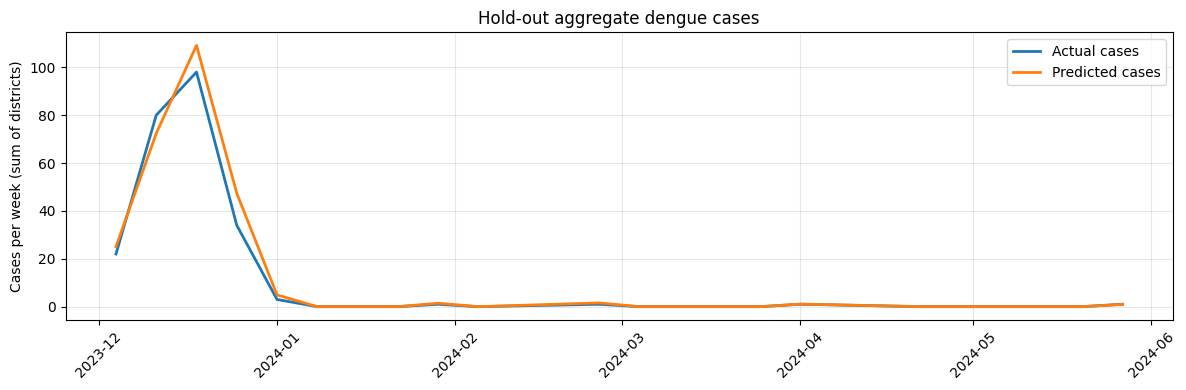

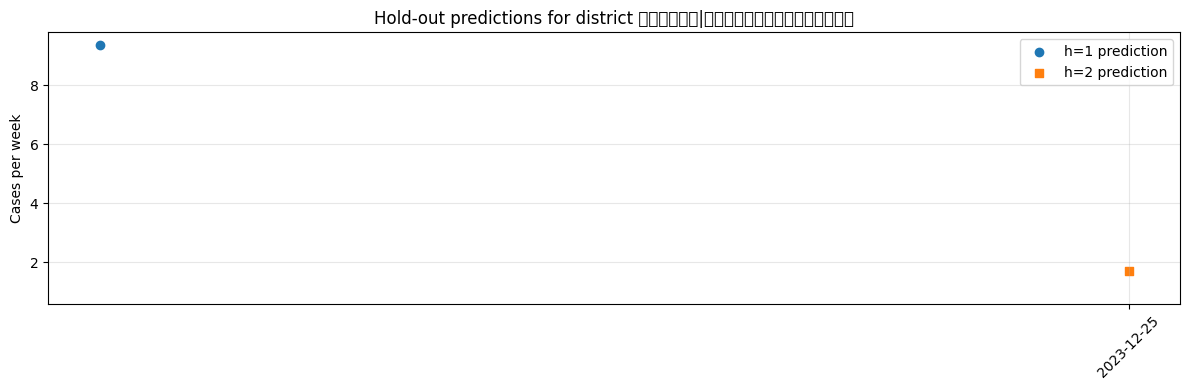

In [33]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
 
# --- Visualization of predictions ---

assert 'hold_predictions' in globals(), "Run the hold-out evaluation cell first."

agg_week = (
    hold_predictions.groupby('ds')[['y', 'y_pred']]
    .sum()
    .reset_index()
    .sort_values('ds')
)

plt.figure(figsize=(12, 4))
plt.plot(agg_week['ds'], agg_week['y'], label='Actual cases', linewidth=2)
plt.plot(agg_week['ds'], agg_week['y_pred'], label='Predicted cases', linewidth=2)
plt.title('Hold-out aggregate dengue cases')
plt.ylabel('Cases per week (sum of districts)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

focus_id = agg_district.index[0] if 'agg_district' in globals() and len(agg_district) else hold_predictions['unique_id'].iloc[0]
focus_df = (
    hold_predictions[hold_predictions['unique_id'] == focus_id]
    .sort_values(['ds', 'h'])
)

plt.figure(figsize=(12, 4))
for h, marker in zip(sorted(focus_df['h'].unique()), ['o', 's', 'D', '^']):
    sub = focus_df[focus_df['h'] == h]
    plt.plot(sub['ds'], sub['y'], linestyle='--', color='tab:gray', alpha=0.4)
    plt.scatter(sub['ds'], sub['y_pred'], label=f'h={h} prediction', marker=marker)

plt.title(f'Hold-out predictions for district {focus_id}')
plt.ylabel('Cases per week')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Top 20 features by combined score:


,feature,combined_score,gain_importance,perm_importance
19,age_mean,0.690698,335092.267577,0.717969
17,ipd_rate,0.095868,36021.432328,0.138074
22,cases_ema4,0.064249,22831.485773,0.097330
23,cases_ema8,0.026096,17805.078444,0.008281
42,cases_roll4_mean,0.021586,4693.364566,0.043606
44,cases_roll6_mean,0.016831,9284.956778,0.013396
48,cases_volatility8,0.011771,1632.260111,0.027174
49,cases_zscore_cluster,0.008132,1219.317038,0.018439
27,cases_lag2,0.004894,205.112449,0.013034
24,cases_lag1,0.004303,532.287118,0.010171


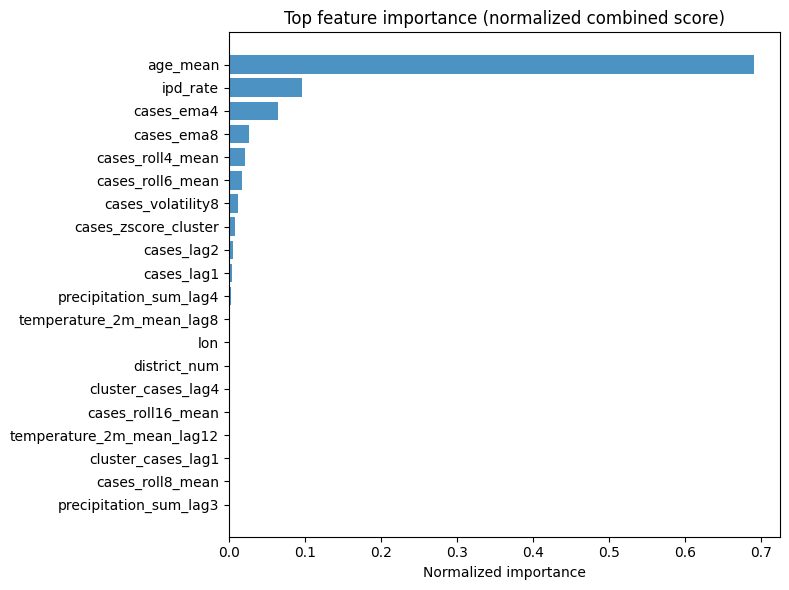

In [34]:

assert 'combined_score' in globals(), "Run the feature selection cell first."

importance_df = pd.DataFrame({
    'feature': combined_score.index,
    'combined_score': combined_score.values,
    'gain_importance': gain_series.reindex(combined_score.index).fillna(0.0).values,
    'perm_importance': perm_series.reindex(combined_score.index).fillna(0.0).values,
})
importance_df = importance_df.sort_values('combined_score', ascending=False)

print('Top 20 features by combined score:')
display(importance_df.head(20))

plot_imp = importance_df.head(20).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(plot_imp['feature'], plot_imp['combined_score'], color='tab:blue', alpha=0.8)
plt.title('Top feature importance (normalized combined score)')
plt.xlabel('Normalized importance')
plt.tight_layout()
plt.show()


In [35]:

import cloudpickle
from datetime import datetime

phase_dir = MODELS / 'phase3_v3'
phase_dir.mkdir(parents=True, exist_ok=True)

artifact = {
    'created_utc': datetime.utcnow().isoformat() + 'Z',
    'cut_date_valid': str(cut_date),
    'features': SELECTED_FEATURES,
    'static_features': static_feats,
    'extra_lags': extra_lags,
    'extra_rolls': extra_rolls,
    'diff_windows': diff_windows,
    'freq': 'W-MON',
    'model_name': 'lgb_poisson',
    'rng_seed': RNG_SEED,
    'notes': 'v3 feature selection + leakage-safe split'
}

with open(phase_dir / 'fcst_model.pkl', 'wb') as f:
    cloudpickle.dump(fcst, f)
with open(phase_dir / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(artifact, f, ensure_ascii=False, indent=2)

print('Saved model →', phase_dir / 'fcst_model.pkl')
print('Saved metadata →', phase_dir / 'metadata.json')


/tmp/ipykernel_28633/3307798535.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'created_utc': datetime.utcnow().isoformat() + 'Z',


Saved model → /teamspace/studios/this_studio/data/dengue/models/phase3_v3/fcst_model.pkl
Saved metadata → /teamspace/studios/this_studio/data/dengue/models/phase3_v3/metadata.json


(h: int, before_predict_callback: Optional[Callable] = None, after_predict_callback: Optional[Callable] = None, new_df: Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame, NoneType] = None, level: Optional[List[Union[int, float]]] = None, X_df: Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame, NoneType] = None, ids: Optional[List[str]] = None) -> Union[pandas.core.frame.DataFrame, utilsforecast.compat.pl_DataFrame]
